# Telco Churn Final Report

## Key Take-Aways From This Report
- $\approx 0.27$ of customers are churning per month
- Customers with month-to-month, fiber optic service, and electronic check are high predictors of churn; in addition, churned customers tend to pay more per-month.
- Recommendation: 
    1. Promote longer contracts, and services that correctly meet customer needs (perhaps through additional services). 
    2. Reduce monthly charges early on in a customer relationship by offering discounts

## Final Reports Contents <a name='contents'></a>

1. <a href='#introduction'>Introduction</a>
    1. <a href='#goals'>Goals and Deliverables</a>
    2. <a href='#hypothesis'>Initial Hypothesis/Questions</a>
2. <a href='#dataintro'>Introduction to the Data</a>
3. <a href='#acquire'>Acquire Data</a>
4. <a href='#prepare'>Prepare Data</a>
5. <a href='#explore'>Explore Data</a>
    1. <a href='#permonth'>Are churned customers paying more per month?</a>
    2. <a href='#churncontract'>Is churn associated with a contract type?</a>
    3. <a href='#churninternettype'>Is churn associated with internet service type?</a>

The following Python modules and constants are used in this project:

In [99]:
import pandas as pd
import itertools
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import acquire
import prepare

rand_seed = prepare.RAND_SEED #to use for the model building
alpha = 0.05 #used for hypothesis testing

## Introduction <a name='introduction'></a>

This project explores the Telco data set to determine the variables of customer churn. It includes the full data science pipline: acquiring and cleaning the data, exploring and visualizing the data, and finally using a model to predict churn.

### Goals and Deliverables <a name='goals'></a>

- Goals
	- Identify at least 3 variables that predict churn
	- A model that is at least 0.75 accurate
	- A report communicating the data science pipeline process
- Deliverables
	- This readme
	- A final report Jupyter Notebook with clean code
	- Python modules automating the acquire and preparation of the data
	- A CSV of data predictions

### Initial Hypothesis/Questions <a name='hypothesis'></a>

- I expect that contract and payment types are the most important predictors of churn
	- People who pay more and see it every month are reminded of the money they are spending and can make a value judgement on whether or not they want to spend their money
- Are additional services important parts of churn?
	- Are people more reluctant to leave the company if they have certain services?


<a href='#contents'>To Top</a>

## Introduction to the Data <a name='dataintro'></a>

Every row in the data represents an individual customer, and includes data on their relationship with the Telco company.  Each customer has a unique ID consisting of numerics and alphabetic chars.  Basic demographic information is available, consisting of gender, partner status, dependent status, and senior citizen status.  The rest of the columns contain information on the customer's relationship with the company.  

#### Customer Identification and Demographic Data:
- Customer ID (String)
- Gender (Male/Female)
- Partner status (Bool)
- Dependent status (Bool)
- Senior citizen status (Bool)

#### Customer Relationship information:
- Tenure in months (float)
- Monthly charges (\$USD) (float)
- Total charges (\$USD) (float)
- Paperless Billing (Bool)
- Payment type (categorical)
- Phone Service, with service option columns:
    - Multiple lines : One Line, Multiple Lines, No Phone Service (categorical)
- Internet Service Type: Fiber Optic, DSL, None (categorical)
- Internet Service Option columns (all bool):
    - Online security
    - Online backup
    - Device protection
    - Tech support
    - Streaming TV
    - Streaming movies
- Churn status (bool)


<a href='#contents'>To Top</a>

## Acquire the Data <a name='acquire'></a>

A custom acquire module is used to retrieve the data from the CodeUp MySQL database.  This module includes the following function signature:
- `get_telco_data(query_db=False)` : Queries the database, or-if a `telco.csv` is present-opens a file to retrieve the data needed for this project.  The data is then cast to a DataFrame and returned to the call location.
    - `query_db=True` will force a database query even if a `telco.csv` file is present, and the existing `telco.csv` file will be overwritten.
    
The following MySQL command is used:

`SELECT c.*, ct.contract_type, pt.payment_type, iso.internet_service_type
    FROM customers AS c
        JOIN contract_types AS ct USING (contract_type_id)
        JOIN payment_types AS pt USING (payment_type_id)
        JOIN internet_service_types AS iso USING (internet_service_type_id);`

In [22]:
df = acquire.get_telco_data() # call the custom function and store returned dataframe in the df variable
df.head(3) # display the first three rows of the dataframe variable

Returning saved csv file.


,Unnamed: 0,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,...,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,contract_type,payment_type,internet_service_type
0,0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,1,...,No,2,Yes,2,65.6,593.3,No,One year,Mailed check,DSL
1,1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,...,Yes,1,No,2,59.9,542.4,No,Month-to-month,Mailed check,DSL
2,2,0004-TLHLJ,Male,0,No,No,4,Yes,No,2,...,No,1,Yes,1,73.9,280.85,Yes,Month-to-month,Electronic check,Fiber optic


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                7043 non-null   int64  
 1   customer_id               7043 non-null   object 
 2   gender                    7043 non-null   object 
 3   senior_citizen            7043 non-null   int64  
 4   partner                   7043 non-null   object 
 5   dependents                7043 non-null   object 
 6   tenure                    7043 non-null   int64  
 7   phone_service             7043 non-null   object 
 8   multiple_lines            7043 non-null   object 
 9   internet_service_type_id  7043 non-null   int64  
 10  online_security           7043 non-null   object 
 11  online_backup             7043 non-null   object 
 12  device_protection         7043 non-null   object 
 13  tech_support              7043 non-null   object 
 14  streamin

Key acquire take-aways:
- 7043 rows are retrieved and 24 columns are retrieved

<a href='#contents'>To Top</a>

## Prepare the Data <a name='prepare'></a>


A custom module is used to prepare the data acquired from the database.  It contains the following relevant function signature:
- `prep_telco(df)` : Given the acquired dataframe, this drops the foreign keys from the SQL. It also drops the rows without a `total_charges` value; `total_charges` are then cast to `float` data type. Returns a prepared dataframe object.
    - The rows dropped in `total_charges` are rows that have `tenure=0`; a `total_charges` of $0$ could be infered--however, there are only $11$ rows where this happens and therefore it represents only $0.0016$ of the original date, i.e. not enough rows to make a difference.
- `split_telco_data(df)` : Given a prepared dataframe, this will return train, validate and test subsets of the dataframe.
    - The `statify` parameter is used for `sklearn.model_selection.test_train_split()` to ensure that churned customers are equally distributed over the subsets

(More information on the code that these functions are made of can be seen in the `prepare.py` comments, and in the `README.md` appendices.

In [24]:
df_prep = prepare.prep_telco(df) #split the dataframe into three subsets
train, validate, test = prepare.split_telco_data(df_prep)
train.head(3)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,payment_type,internet_service_type
5919,8331-ZXFOE,Female,0,No,No,58,Yes,Yes,Yes,Yes,...,Yes,No,No,Yes,71.10,4299.20,No,One year,Credit card (automatic),DSL
1915,2790-XUYMV,Male,0,No,Yes,71,Yes,Yes,Yes,Yes,...,No,No,No,Yes,85.45,6028.95,No,One year,Credit card (automatic),Fiber optic
5054,7107-UBYKY,Female,0,Yes,Yes,35,Yes,Yes,No internet service,No internet service,...,No internet service,No internet service,No internet service,Yes,25.75,882.55,No,Month-to-month,Electronic check,None


In [25]:
train.shape #there are 3943 rows and 25 columns

(3937, 21)

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3937 entries, 5919 to 4192
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            3937 non-null   object 
 1   gender                 3937 non-null   object 
 2   senior_citizen         3937 non-null   int64  
 3   partner                3937 non-null   object 
 4   dependents             3937 non-null   object 
 5   tenure                 3937 non-null   int64  
 6   phone_service          3937 non-null   object 
 7   multiple_lines         3937 non-null   object 
 8   online_security        3937 non-null   object 
 9   online_backup          3937 non-null   object 
 10  device_protection      3937 non-null   object 
 11  tech_support           3937 non-null   object 
 12  streaming_tv           3937 non-null   object 
 13  streaming_movies       3937 non-null   object 
 14  paperless_billing      3937 non-null   object 
 15  m

Key prepare take-aways:
- 11 rows are dropped due to lack of data in the `total_charges` column
- Data is split into train, validate, and test subsets

<a href='#contents'>To Top</a>

## Exploring the Data <a name='explore'></a>

The `train` data set is used to explore the data. 

The first to understand is the extent of churn within the data.

Key take-aways:
- Churn rate for the overall sample is $\approx0.27$
- This represents $\approx1000$ customers

In [37]:
train.churn.value_counts() #get the values of the churn column

No     2891
Yes    1046
Name: churn, dtype: int64

In [60]:
proportion_churn = (train.churn == 'Yes').mean() #get the proportion of customers who churn
proportion_churn

0.2656845313690627

Text(0.5, 0, 'Churn')

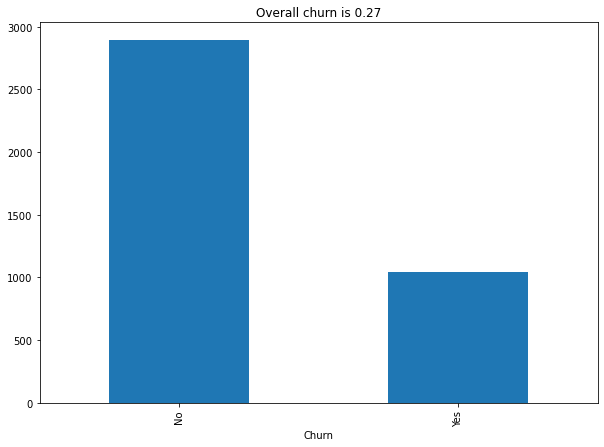

In [68]:
# plot the churn proortions
plt.figure(figsize=(10,7)) # make figure larger
train.churn.value_counts().plot.bar() # make the bar plot with the data
plt.title(f'Overall churn is {proportion_churn:.2}') # set the plot title
plt.xlabel('Churn') # Set the x-axis label

### Are churned customers paying more per month? <a name = 'permonth'></a>


#### Visualize

There are three columns that are numeric: `tenure`, `monthly_charges`, and `total_charges`. Each of these can be plotted to see the differences between churned and non-churned customers.

In [76]:
#make a dataframe of just the numeric columns and churn
train_numerics = train[['tenure', 'monthly_charges', 'total_charges', 'churn']]

Text(0.5, 0, 'Churn')

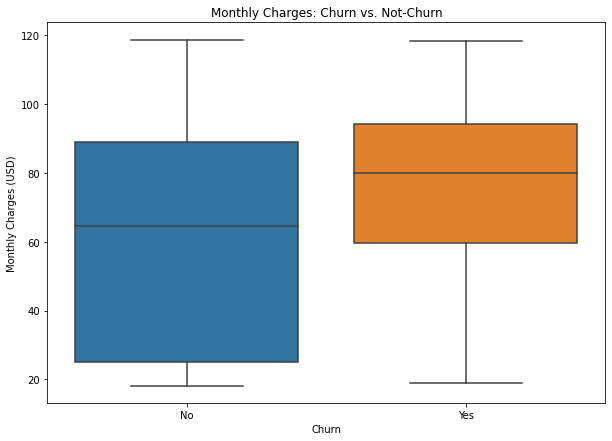

In [103]:
plt.figure(figsize=(10,7)) # make figure larger
sns.boxplot(data=train_numerics, x='churn', y='monthly_charges') #plot monthly charges
plt.title(f'Monthly Charges: Churn vs. Not-Churn') # set the plot title
plt.ylabel('Monthly Charges (USD)') #set ylabel
plt.xlabel('Churn') #set x label

In [87]:
# same information numerically
train_numerics.groupby('churn')['monthly_charges'].describe().T

churn,No,Yes
count,2891.000000,1046.000000
mean,61.218091,74.719216
std,31.349533,24.593969
min,18.250000,18.850000
25%,25.000000,59.525000
50%,64.500000,79.850000
75%,89.025000,94.237500
max,118.650000,118.350000


#### Perform hypothesis testing

Consider the distribution of monthly charges.  It is roughly normally distributed.  See graph below, and that the mean and median are different by $\approx 6$ (normally distributed $\implies \text{mean} = \text{median}$).  Therefore perform a t-test on the column.

<AxesSubplot:>

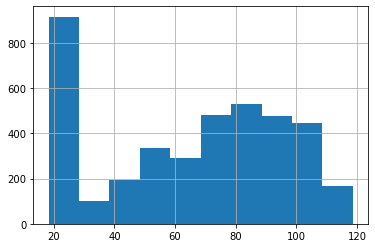

In [93]:
train.monthly_charges.hist()

In [92]:
train.monthly_charges.mean(), train.monthly_charges.median()

(64.80513081026147, 70.25)

Perform a t-test to determine the following:

$H_0$ : The mean monthly charges among churned customers is *less than or equal to* that of unchurned customers

$H_a$ : The mean monthly charges among churned customers is *greater than* that of unchurned customers

In [100]:
churn_series = train[train.churn == 'Yes'].monthly_charges
nochurn_series = train[train.churn == 'No'].monthly_charges
l_t, l_p = stats.levene(churn_series, nochurn_series)
levene_bool = not l_p < alpha
    #now do the t test
t, p = stats.ttest_ind(churn_series, nochurn_series, equal_var= levene_bool)
p/2 < alpha, p

(True, 2.460130776937842e-43)

In [101]:
if p/2 < alpha:
    print('Null hypothesis is likely false')
else:
    print('Null hypothesis is likely true')

Null hypothesis is likely false


*Conclusion*: The mean monthly charges is most likely higher among customers who churn than those who do not churn."

Key take away:
- Churned customers are paying more per month
    - `total_charges` can be inferred from the `monthly_charges` column.  
    
<a href='#contents'>To Top</a>

### Is churn associated with a contract type? <a name='churncontract'></a>


#### Visualize

Consider churn among different contract types.

Three contract types: Month-to-Month, One Year, Two Year

Text(0, 0.5, 'Number of customers')

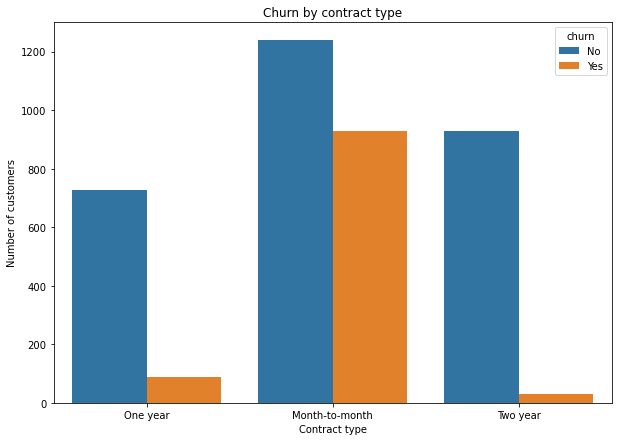

In [112]:
plt.figure(figsize=(10,7)) # make figure larger
sns.countplot(data=train, x='contract_type', hue='churn')
plt.title('Churn by contract type')
plt.xlabel('Contract type')
plt.ylabel('Number of customers')

In [115]:
#proportion shown numerically:
# group the data by contract type an calculate the count of rows for each one
pd.DataFrame(train.groupby('contract_type').churn.value_counts()) 

churn
contract_type  churn       
Month-to-month No      1238
               Yes      927
One year       No       726
               Yes       89
Two year       No       927
               Yes       30

In [123]:
#as a percentage
outputs = []
cat_var = ['contract_type']
for cat in cat_var:
    for subcat in list(train[cat].unique()):
        prop = (train[train[cat] == subcat].churn == 'Yes').mean()  
        sample_prop = train[train[cat] == subcat].shape[0]/train.shape[0]
        output = {
            'Category':'Contract type',
            'Subcategory':subcat,
            'Churn rate':prop,
        }
        outputs.append(output)
pd.DataFrame(outputs)

,Category,Subcategory,Churn rate
0,Contract type,One year,0.109202
1,Contract type,Month-to-month,0.428176
2,Contract type,Two year,0.031348


#### Perform hypothesis testing

Visually and numerically it appears that month-to-month customers. Perform hypothesis testing on the following:

$H_0$ : Month to month contracts are independent of churn.

$H_a$ : Month to month contracts are not independent of churn.

In [140]:
#seperate out 
contract_hypothesis = train[['churn', 'contract_type']]
contract_hypothesis['monthly_contract'] = (contract_hypothesis.contract_type == 'Month-to-month')

/var/folders/lw/_43z7rb5635_x1dwsyzrnc_m0000gn/T/ipykernel_39565/240837508.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contract_hypothesis['monthly_contract'] = (contract_hypothesis.contract_type == 'Month-to-month')


In [145]:
obs = pd.crosstab(contract_hypothesis.churn, contract_hypothesis.monthly_contract)
chi2, p, degf, expected = stats.chi2_contingency(obs)
chi2, p

(649.1331915563476, 3.4484593947893894e-143)

In [143]:
if p < alpha:
    print('Null hypothesis is likely false')
else:
    print('Null hypothesis is likely true')

Null hypothesis is likely false


*Conclusion*: Churn is most likely dependent on churn.

Key take away:
- Because of the high $χ^2$  value, it is very likely that churn is not independent on Month-to-Month contract status

<a href='#contents'>To Top</a>

### Is churn associated with internet service type? <a name='churninternettype'></a>

#### Visualize

Consider customers by their internet service type.

Text(0, 0.5, 'Number of customers')

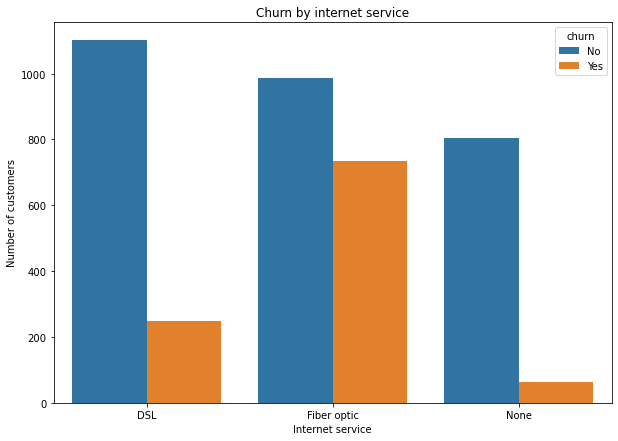

In [148]:
plt.figure(figsize=(10,7)) # make figure larger
sns.countplot(data=train, x='internet_service_type', hue='churn')
plt.title('Churn by internet service')
plt.xlabel('Internet service')
plt.ylabel('Number of customers')